# Project : AT&T Spam Detector 2/2
## Using a pretrained embedding model *(transfer learning)*

In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

# model building
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# split data into train and test set
from sklearn.model_selection import train_test_split

# plot lib
import matplotlib.pyplot as plt

# score handling
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('src/spam.csv', encoding = "ISO-8859-1")

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# With 0.99 percent of missing values, I will remove these 3 columns :
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

# I will rename our main columns with relevant names 
# I will replace the labels by 0(ham) and 1(spam)
df = df.rename(columns={"v1":"label", "v2":"sms_content"})
df['label'] = df['label'].map( {'spam': 1, 'ham': 0} )
df.head()

,label,sms_content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
X = df['sms_content']
y = df['label']

In [6]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(X,y, test_size=0.15)

In [7]:
# Batch
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [8]:
train_examples_batch, train_labels_batch = next(iter(train.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'Japanese Proverb: If one Can do it, U too Can do it, If none Can do it,U must do it Indian version: If one Can do it, LET HIM DO it.. If none Can do it,LEAVE it!! And finally Kerala version: If one can do it, Stop him doing it.. If none can do it, Make a strike against it ...',
       b'FreeMSG You have been awarded a FREE mini DIGITAL CAMERA, just reply SNAP to collect your prize! (quizclub Opt out? Stop 80122300p/wk SP:RWM Ph:08704050406)',
       b' what number do u live at? Is it 11?',
       b'Me hungry buy some food good lei... But mum n yun dun wan juz buy a little bit... ',
       b'IMPORTANT MESSAGE. This is a final contact attempt. You have important messages waiting out our customer claims dept. Expires 13/4/04. Call 08717507382 NOW!',
       b'Kind of. Took it to garage. Centre part of exhaust needs replacing. Part ordered n taking it to be fixed tomo morning.',
       b'Cuz ibored. And don wanna study',
       b"Our Pr

In [9]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int64)>

### I will use the **pretrained embedding model** : google/nnlm-en-dim50/2 :
- *source Tensorflow Hub     : https://tfhub.dev/google/nnlm-en-dim50/2*
- *Text embedding with pre-built OOV. Maps from text to 50-dimensional embedding vectors*
- *The module preprocesses its input by splitting on spaces*
- *Small fraction of the least frequent tokens and embeddings (~2.5%) are replaced by hash buckets*
- *Word embeddings are combined into sentence embedding using the **sqrtn** combiner*

##### Additional informations :
- *source Tensorflow tutorials : https://www.tensorflow.org/tutorials/keras/text_classification_with_hub*
- *Benefit from **transfer learning***
- *Text preprocessing not necessary*

In [10]:
# Downloading pre trained model

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"                      # --> Run well 
#embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"                    Time computing is a little bit long and overfit
#embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2" Time computing is too long
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)


### Building our model

In [11]:

from keras.layers import LSTM
# RNN seems to be integrated in Hub layer
# Moreover, Hub layer output is not sequential
# In this context, I will use Dense layers.

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,192,777
Trainable params: 48,192,777
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
history = model.fit(train.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=val.batch(512),
                    verbose=1)


Epoch 1/30
10/10 [==============================] - 11s 999ms/step - loss: 0.6606 - accuracy: 0.7876 - val_loss: 0.6329 - val_accuracy: 0.8493
Epoch 2/30
10/10 [==============================] - 10s 988ms/step - loss: 0.5999 - accuracy: 0.8765 - val_loss: 0.5670 - val_accuracy: 0.8541
Epoch 3/30
10/10 [==============================] - 10s 985ms/step - loss: 0.5221 - accuracy: 0.8750 - val_loss: 0.4839 - val_accuracy: 0.8529
Epoch 4/30
10/10 [==============================] - 10s 1s/step - loss: 0.4271 - accuracy: 0.8729 - val_loss: 0.3891 - val_accuracy: 0.8541
Epoch 5/30
10/10 [==============================] - 11s 1s/step - loss: 0.3292 - accuracy: 0.8771 - val_loss: 0.3083 - val_accuracy: 0.8660
Epoch 6/30
10/10 [==============================] - 11s 1s/step - loss: 0.2505 - accuracy: 0.9012 - val_loss: 0.2456 - val_accuracy: 0.9019
Epoch 7/30
10/10 [==============================] - 11s 1s/step - loss: 0.1901 - accuracy: 0.9419 - val_loss: 0.1902 - val_accuracy: 0.9390
Epoch 8/30


### Model results and evaluation

In [14]:
results = model.evaluate(val.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))


2/2 - 0s - loss: 0.0754 - accuracy: 0.9797 - 221ms/epoch - 111ms/step
loss: 0.075
accuracy: 0.980


In [15]:
ypred_train = (model.predict(xtrain) > 0.5).astype("int32")
ypred_val = (model.predict(xval) > 0.5).astype("int32")

27/27 [==============================] - 3s 115ms/step


In [16]:
print(f"accuracy score on train set : {accuracy_score(ytrain, ypred_train)}")
print(f"accuracy score on validation set : {accuracy_score(yval, ypred_val)}")

accuracy score on train set : 1.0
accuracy score on validation set : 0.9796650717703349


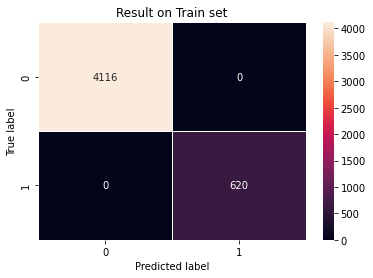

In [17]:
mtx = confusion_matrix(ytrain, ypred_train)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Train set')
plt.show()


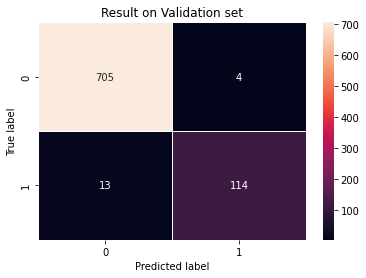

In [18]:
mtx = confusion_matrix(yval, ypred_val)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Validation set')
plt.show()

#### Take a look at the **history** recorded by our model, convergence sounds good.

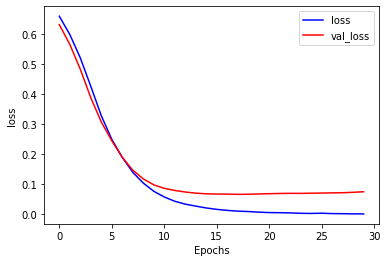

In [19]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b", label='loss')
plt.plot(history.history["val_loss"], color="r", label='val_loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.show()


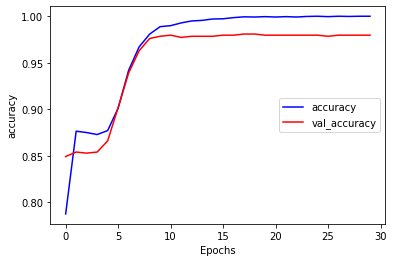

In [20]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b", label='accuracy')
plt.plot(history.history["val_accuracy"], color="r", label='val_accuracy')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend(loc="right")
plt.show()

### Optionnal : Saving model and history

In [21]:
# model.save("model_embedding_pretrained.h5")

In [22]:
# import json
# json.dump(model.history.history, open("embedding_pretrained_history.json", 'w'))

### Conclusion :
- This model allow us to avoid text cleaning and more, it perform very well
- Even if the time computing is quite long, it seems to be a very good solution
- It was Difficult to test google/universal-sentence-encoder/4 on my own PC due to the time computing very important
- I tried https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2 : very interesting, the results were very good with a drawback: overfitting to handle